# 비트코인 추세 분석 및 시세 예측

In [5]:
import os
Join = os.path.join
VAR_DIR  = Join(os.getcwd(), "var")

import datetime
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 8)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 80)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (14,5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

### 비트코인 시세 및 볼륨

In [22]:
CSV_PATH = Join(VAR_DIR, '4h.csv')
bitcoin_df = pd.read_csv(CSV_PATH, sep=',', header=0, names=['day', 'price', 'hightesPrice', 'lowerPrice', 'closePrice', 'volume'])

               price
day                 
2017-08-18   4292.39
2017-08-18   4285.00
2017-08-18   4320.52
2017-08-19   4234.54
2017-08-19   4135.00
...              ...
2024-10-04  61443.64
2024-10-04  61449.84
2024-10-05  61873.05
2024-10-05  62368.00
2024-10-05  62086.00

[15614 rows x 1 columns]


C:\Project\BitcoinTrade\.venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Project\BitcoinTrade\.venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='day'>

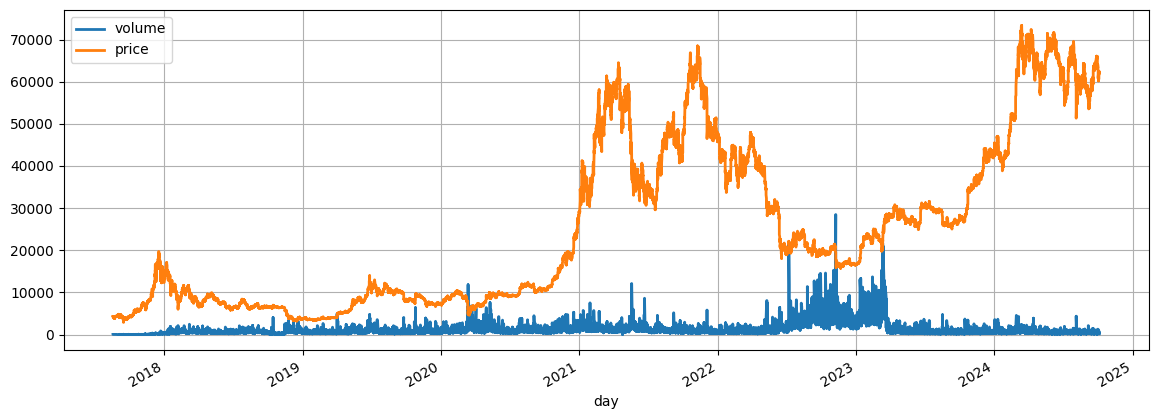

In [34]:
df = bitcoin_df[['day', 'volume', 'price']]
df['volume'] = df['volume'] / 10

df['day'] = pd.to_datetime(df['day'])
df.index = df['day']

df.set_index('day', inplace=True)
print(df[['price']])

df.plot()

##### 로그 시세

                price
day                  
2017-08-18   8.364599
2017-08-18   8.362876
2017-08-18   8.371131
2017-08-19   8.351030
2017-08-19   8.327243
...               ...
2024-10-04  11.025876
2024-10-04  11.025977
2024-10-05  11.032840
2024-10-05  11.040808
2024-10-05  11.036276

[15614 rows x 1 columns]


<AxesSubplot:xlabel='day'>

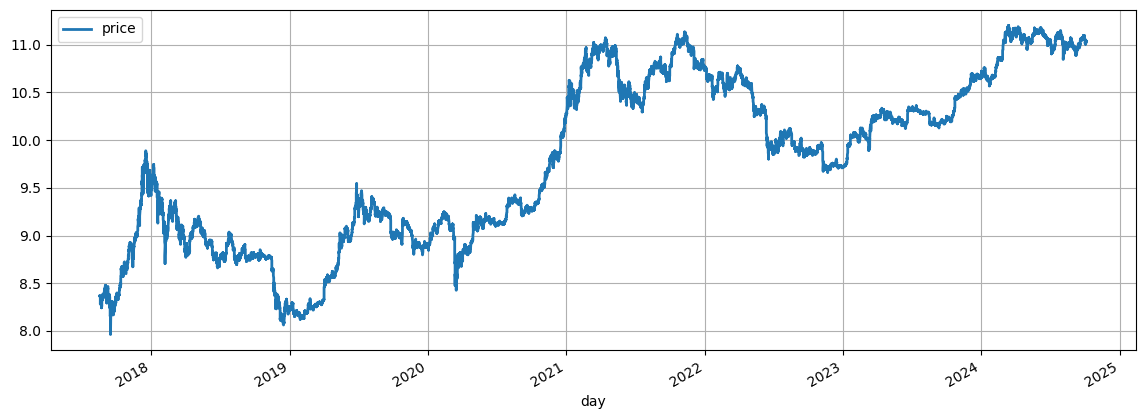

In [9]:
log_df = pd.DataFrame()
log_df['price'] = np.log(bitcoin_df['price'])
log_df['day'] = pd.to_datetime(bitcoin_df['day'])
log_df.index = log_df['day']

log_df.set_index('day', inplace=True)
log_df = log_df.replace([np.inf, -np.inf], np.nan)
print(log_df[['price']])

log_df.plot()

# ARIMA 모델

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                15613
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -117084.405
Method:                       css-mle   S.D. of innovations            437.126
Date:                Sun, 06 Oct 2024   AIC                         234178.811
Time:                        23:55:11   BIC                         234217.090
Sample:                             1   HQIC                        234191.486
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      1.0370      0.025     41.427      0.000       0.988       1.086
ar.L2.D.y     -0.8749      0.020    -43.075      0.000      -0.915      -0.835
ma.L1.D.y     -1.0522      0.021    -49.307      0.0

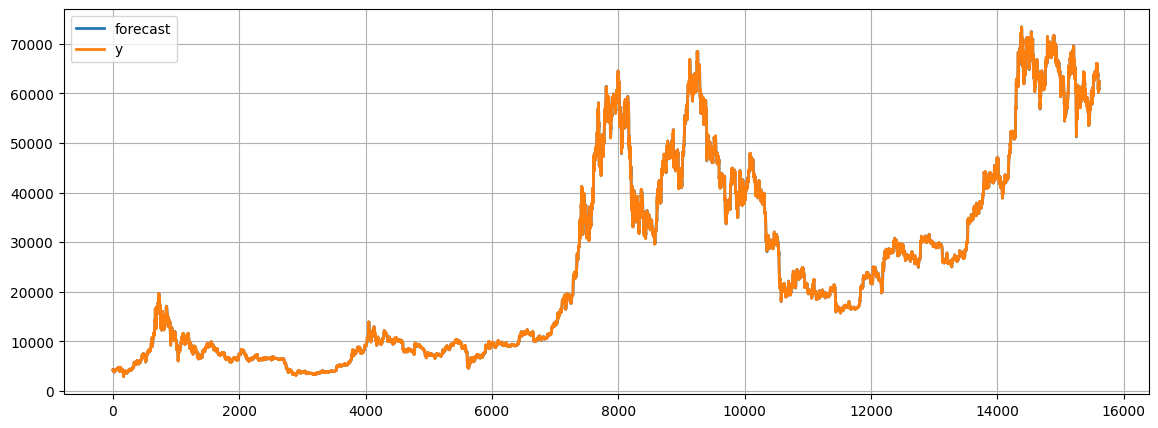

In [10]:
# trend가 c일 경우 t-test결과가 매우 나쁨
bitcoin_train_df =  bitcoin_df[['day',  'price']]
model = ARIMA(bitcoin_train_df.price.values, order = (2,1,2))
model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
print(model_fit.summary())

fig = model_fit.plot_predict()

##### 확대하면 실측 값과 예측 값이 비슷하다

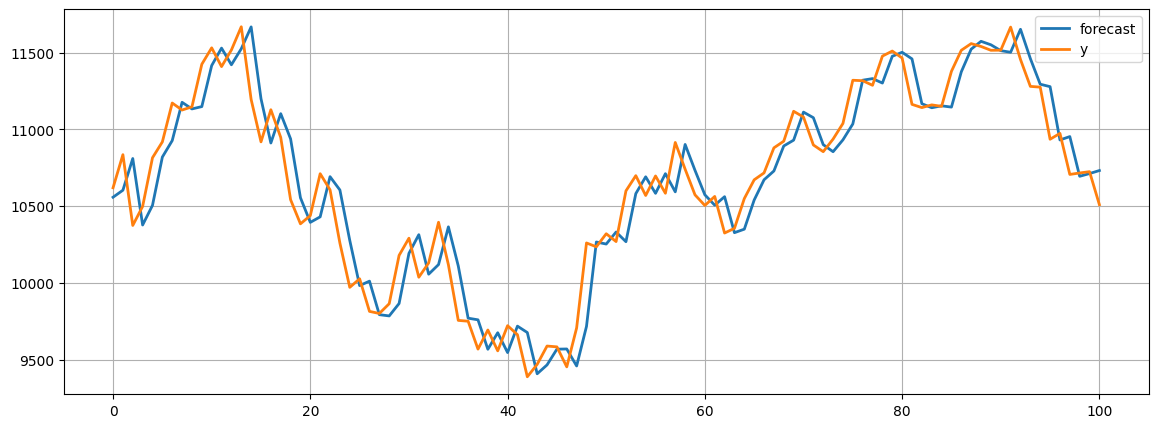

In [11]:
model_fit.plot_predict(start=1100, end=1200)
plt.show()

# 1차 차분 시계열 그래프

<AxesSubplot:>

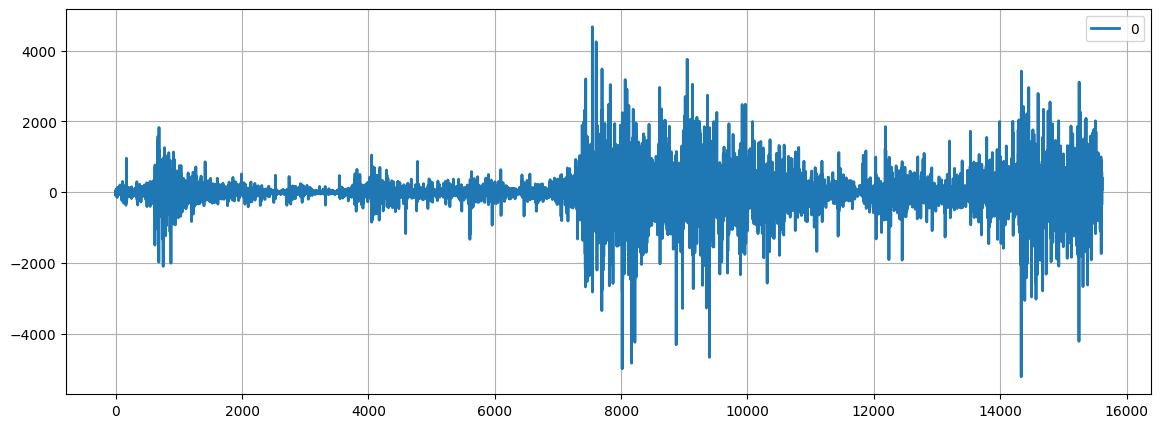

In [12]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

# 가격 예측 모델

C:\Project\BitcoinTrade\.venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


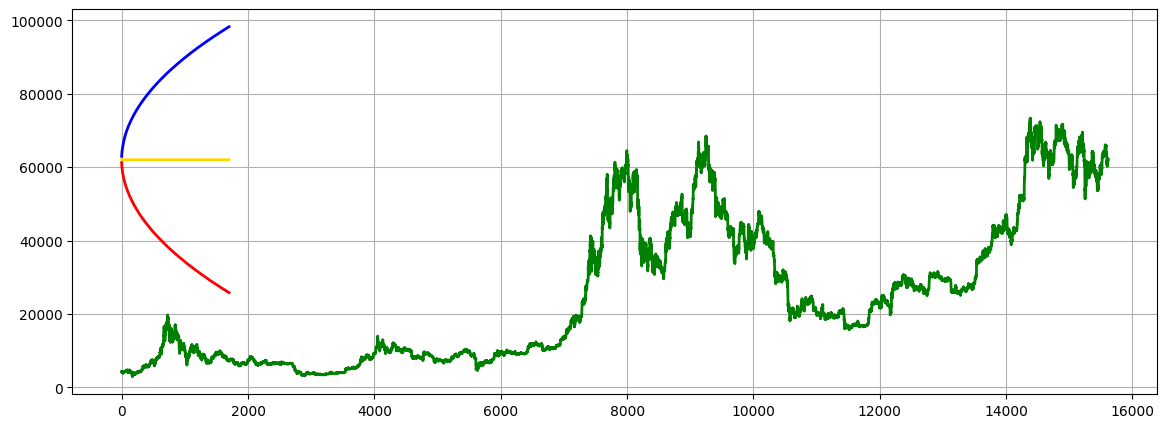

In [13]:
df = bitcoin_df[['day', 'price']]
df['day'] = pd.to_datetime(df['day'])
df.index = df['day']
df.set_index('day', inplace=True)

forecast_data = model_fit.forecast(steps=1700)
pred_y = forecast_data[0].tolist()
test_y = df.price.values

pred_y_lower = []
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)


# 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')    

# Prophet 프레임워크로 시세 예측

In [14]:
from prophet import Prophet

df = bitcoin_df[['day', 'price']]
df.columns = ['ds', 'y']
print(df)

C:\Project\BitcoinTrade\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


               ds         y
0      2017-08-18   4292.39
1      2017-08-18   4285.00
2      2017-08-18   4320.52
3      2017-08-19   4234.54
4      2017-08-19   4135.00
...           ...       ...
15609  2024-10-04  61443.64
15610  2024-10-04  61449.84
15611  2024-10-05  61873.05
15612  2024-10-05  62368.00
15613  2024-10-05  62086.00

[15614 rows x 2 columns]


In [15]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.15)

prophet.fit(df)

23:55:28 - cmdstanpy - INFO - Chain [1] start processing
23:55:39 - cmdstanpy - INFO - Chain [1] done processing


### 200일 예측

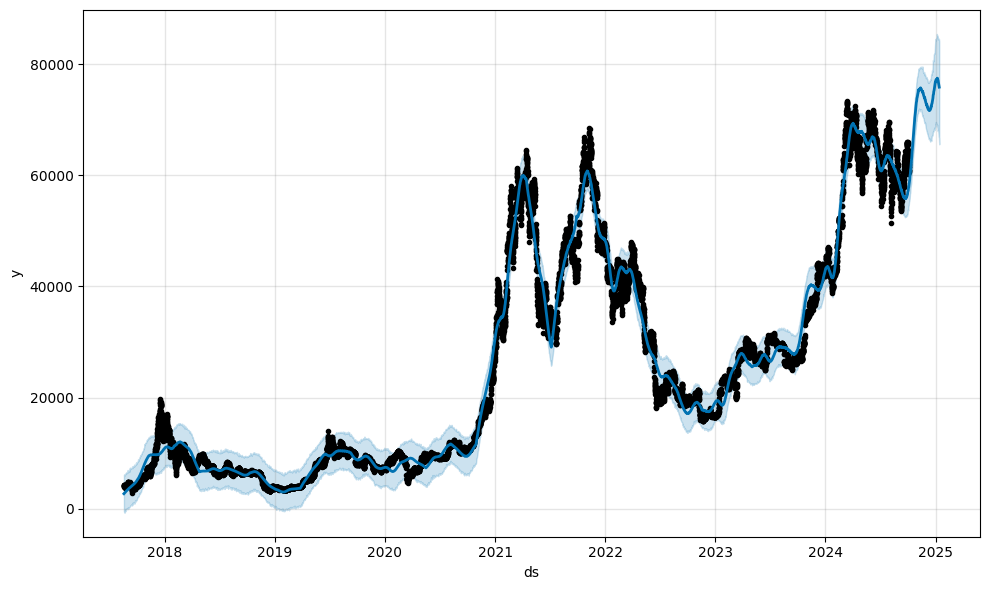

In [19]:
future_data = prophet.make_future_dataframe(periods = 100, freq = 'd')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(30)

fig1 = prophet.plot(forecast_data)

##### 상승하는 추세, 화,목, AM12:00에 변동성이 높다

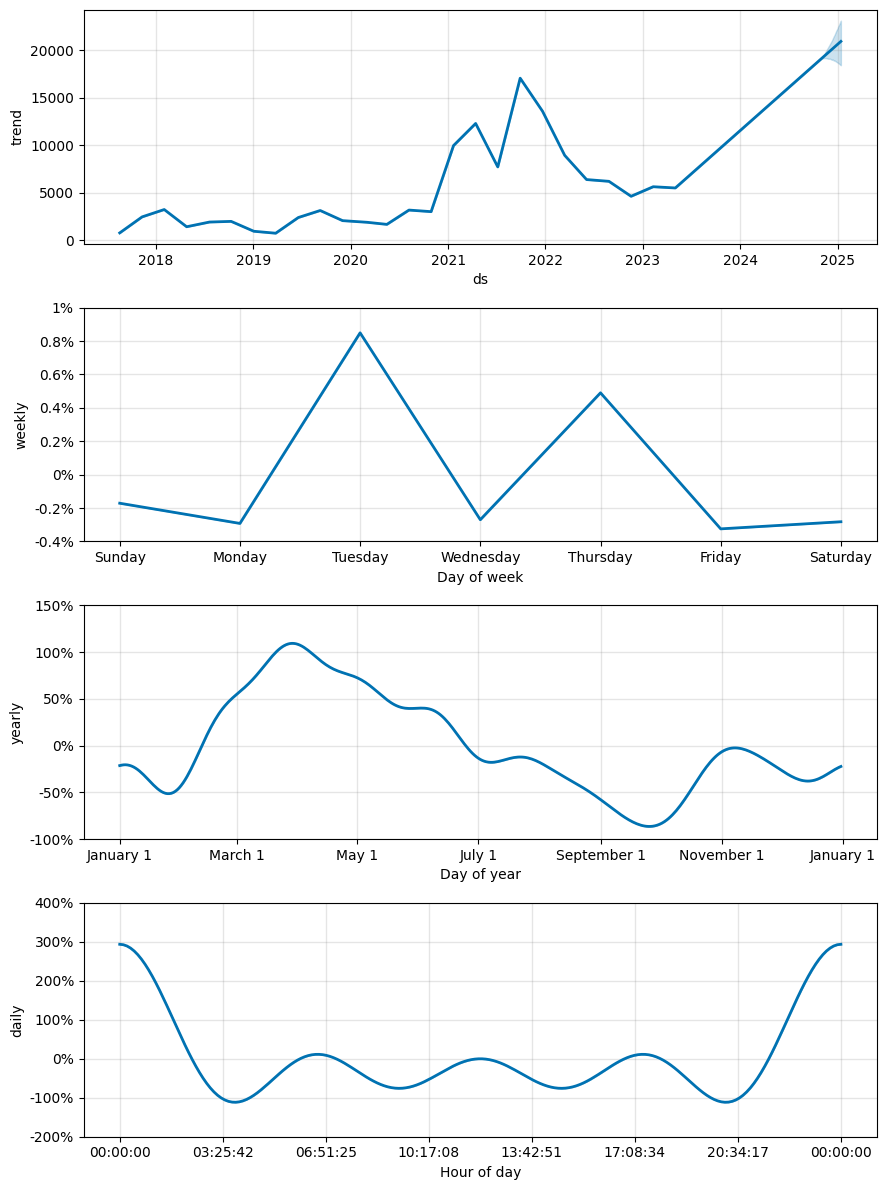

In [35]:
fig2 = prophet.plot_components(forecast_data)